# HW 07

Charlie Perez (cwp5xyj)

### Part 1: Instructions

In [1]:
# 0: setup

import pandas as pd
import numpy as np
from scipy.linalg import norm, eigh

import plotly_express as px
import seaborn as sns

sns.set(style='ticks')

import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

data_prefix = 'novels'

OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [2]:
# 1: import lib and corpus tables

LIB = pd.read_csv(f'{data_home}/{data_prefix}/{data_prefix}-LIB.csv').set_index('book_id')
CORPUS = pd.read_csv(f'{data_home}/{data_prefix}/{data_prefix}-CORPUS.csv').set_index(OHCO)

In [3]:
# 2: extract vocab

VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)

In [4]:
# 3: Compute TFIDF and VOCAB['dfidf'] for the CORPUS using the following parameters:

bag = ['book_id', 'chap_id']
tf_method = 'max'
idf_method = 'standard'

BOW = CORPUS.groupby(bag+['term_str']).term_str.count().to_frame('n')
DTCM = BOW.n.unstack(fill_value=0)
N = DTCM.shape[0]
TF = (DTCM.T / DTCM.T.max()).T
DF = DTCM.astype('bool').sum()
IDF = np.log2(N / DF)
TFIDF = TF * IDF

VOCAB['df'] = DF
VOCAB['dfidf'] = VOCAB.df * np.log2(len(TFIDF)/VOCAB.df)

In [5]:
# 4: create doc table

DOC = TFIDF.index.to_frame().drop(['book_id', 'chap_id'], axis = 1).join(LIB, on='book_id')
DOC.head()

genre_id author_id
book_id    chap_id                   
adventures 1              d     doyle
           2              d     doyle
           3              d     doyle
           4              d     doyle
           5              d     doyle

In [6]:
# 5: reduced table

VOCAB_reduced = VOCAB[VOCAB.max_pos.isin(['NN', 'NNS'])].sort_values(by = 'dfidf', ascending = False).head(1000)
TFIDF_1000 = TFIDF[VOCAB_reduced.index]
TFIDF_1000.shape, TFIDF_1000.index.names

((320, 1000), FrozenList(['book_id', 'chap_id']))

In [7]:
# 6: create PCA function

def PCA_info(X, k=10, norm_docs=False, center_by_mean=False, center_by_variance=False):
    
    global LIB
    
    if norm_docs:
        X = (X.T / norm(X, 2, axis=1)).T
        
    X = X.dropna()
    
    if center_by_mean:
        X = X - X.mean()
    
    if center_by_variance:
        X = X / X.var()
        
    COV = X.T.dot(X) / (X.shape[0] - 1)
    
    eig_vals, eig_vecs = eigh(COV)
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
    EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
    EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)
    
    COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(k).reset_index(drop=True)
    COMPS.index.name = 'comp_id'
    COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
    COMPS.index.name = 'pc_id'
    
    LOADINGS = COMPS[COV.index].T
    LOADINGS.index.name = 'term_str'
    
    DCM = X.dot(LOADINGS) 
    DCM = DCM.join(LIB, on='book_id').reset_index()
    DCM['doc'] = DCM.apply(lambda x: f"{x.author_id} - {x.book_id} ({str.upper(x.genre_id)}) {str(x.chap_id).zfill(2)}", 1)
    
    top_terms = []
    for i in range(k):
        for j in [0, 1]:
            comp_str = ' '.join(LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(10).index.to_list())
            top_terms.append((f"PC{i}", j, comp_str))
    COMP_GLOSS = pd.DataFrame(top_terms).set_index([0,1]).unstack()
    COMP_GLOSS.index.name = 'pc_id'
    COMP_GLOSS.columns = COMP_GLOSS.columns.droplevel(0) 
    COMP_GLOSS = COMP_GLOSS.rename(columns={0:'pos', 1:'neg'})
    
    COMPINF = pd.DataFrame(COMPS['eig_val']).join(COMP_GLOSS, on = 'pc_id')
    
    return LOADINGS, DCM, COMPINF

In [8]:
# 7: pray this works

LOADINGS, DCM, COMPINF = PCA_info(TFIDF_1000, k=10, norm_docs = True) # other two are False by default

In [9]:
print(LOADINGS.shape)
LOADINGS.head()

(1000, 10)


pc_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_str,,,,,,,,,,
yours,-0.033782,0.022305,-0.017247,0.002569,0.005213,0.022219,0.018388,-0.003729,-0.007325,-0.009535
reply,-0.028961,-0.006638,-0.008285,0.011813,0.018095,0.016233,0.010555,0.012620,0.013116,-0.029834
order,-0.033346,0.001702,-0.003277,0.017642,-0.023479,0.012880,0.024671,-0.011810,-0.013153,0.014274
curiosity,-0.033703,-0.015974,-0.013503,0.003522,0.011976,0.007353,0.022919,-0.004304,-0.002200,-0.008870
memory,-0.034680,0.001171,0.000812,-0.019209,0.023375,0.015113,0.002720,0.032005,0.016757,0.013067


In [10]:
print(DCM.shape)
DCM.head()

(320, 15)


,book_id,chap_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,genre_id,author_id,doc
0,adventures,1,-0.544757,0.260811,0.032378,0.027213,-0.023514,-0.168894,0.084074,-0.120973,0.004008,-0.044996,d,doyle,doyle - adventures (D) 01
1,adventures,2,-0.493524,0.314250,0.070413,-0.007845,0.015747,-0.185371,0.068997,-0.103084,0.123698,-0.045848,d,doyle,doyle - adventures (D) 02
2,adventures,3,-0.496395,0.311053,-0.078797,-0.014770,0.012371,-0.124366,0.100964,-0.099923,0.055469,-0.021933,d,doyle,doyle - adventures (D) 03
3,adventures,4,-0.495314,0.181364,-0.030017,-0.040036,-0.058329,-0.124913,0.059483,-0.204471,0.101390,0.135461,d,doyle,doyle - adventures (D) 04
4,adventures,5,-0.486264,0.204159,0.045298,-0.046201,-0.040909,-0.126869,0.097860,-0.028084,0.147257,-0.004150,d,doyle,doyle - adventures (D) 05


In [11]:
COMPINF

,eig_val,pos,neg
pc_id,,,
PC0,0.158126,humanity rank variety mixture apprehensions hi...,castle lady letter aunt chateau father oh cham...
PC1,0.042447,thats youre shes cab girl lawyer police doctor...,chateau castle chamber woods convent apartment...
PC2,0.022221,mountains woods sea rocks whilst road castle m...,brother engagement father son sister letter da...
PC3,0.019398,castle aunt chamber apartment servants corrido...,cottage chateau sea mountains feelings misery ...
PC4,0.018967,chateau thats youre woods shes aunt lawyer gir...,castle blood whilst sleep child monster horror...
PC5,0.015708,thats youre shes guess youve girl oh thoughtfu...,cab chateau dog inquiry police case letter mat...
PC6,0.013440,chateau convent coffee cab crime bed key blood...,mountains castle aunt rocks horses girl sea mo...
PC7,0.012734,aunt whilst sleep aunts mistress patient bag l...,brother castle cab son horse road thats father...
PC8,0.012310,aunt evidence murderer cab murder misery crime...,chateau whilst sleep bed women rooms lady till...


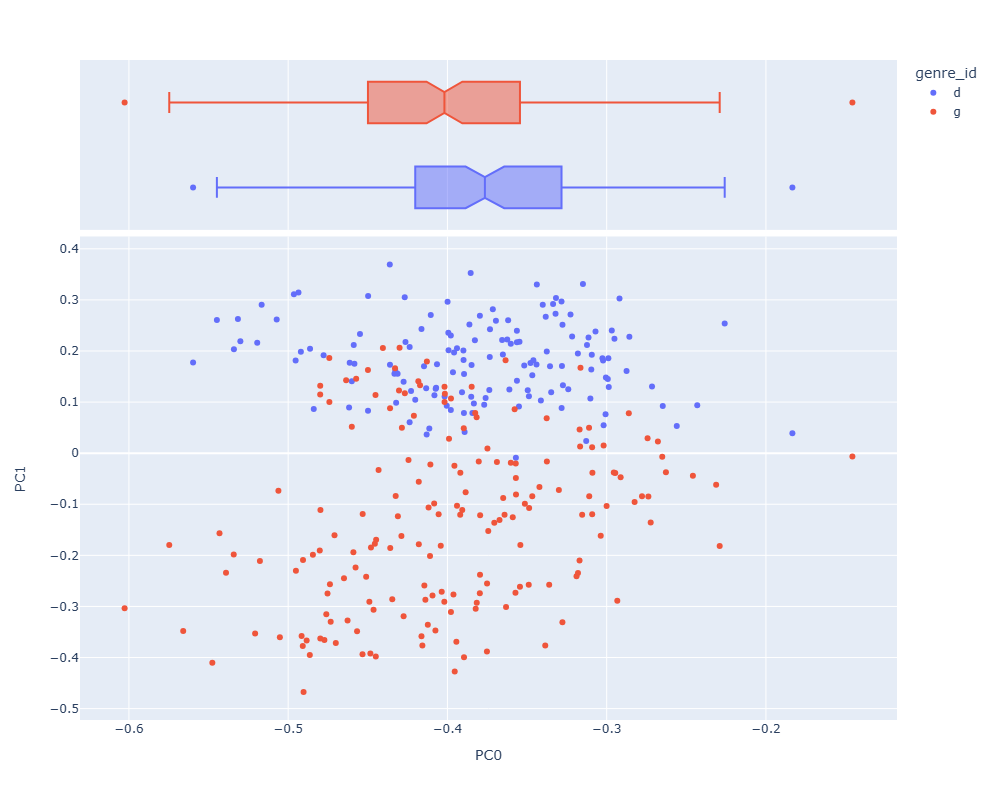

In [47]:
# 8: create some visualizations

px.scatter(DCM, 'PC0', 'PC1', color='genre_id', hover_name='doc', 
           symbol=None, size=None,
           marginal_x='box', height=800)

I am going to elect to stick to the visualizations necessary to answer the questions so as not to make the PDF submission excessively large. Hope that's OK.

## Part 2: Questions

### Question 1: Which genre has the more narrow range?

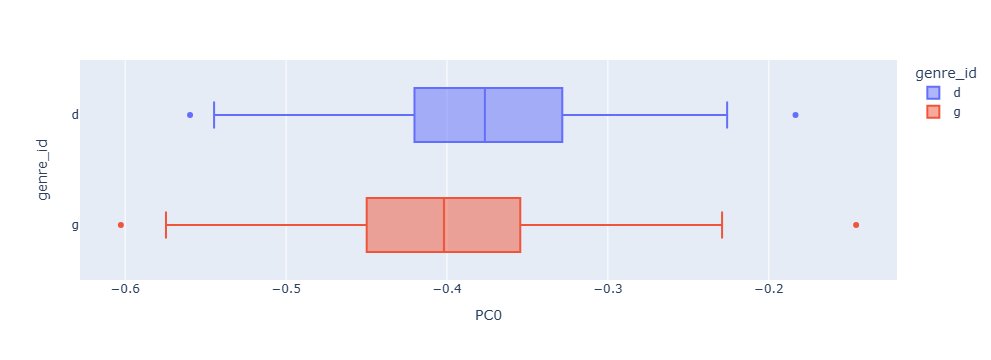

In [13]:
px.box(DCM, 'PC0', 'genre_id', color = 'genre_id', hover_name = 'doc')

From this observation, it appears that the **detective** genre has the more narrow range - while the IQR is pretty similar, gothic has more extremes.

### Question 2: Which author has the highest absolute value of PC0?

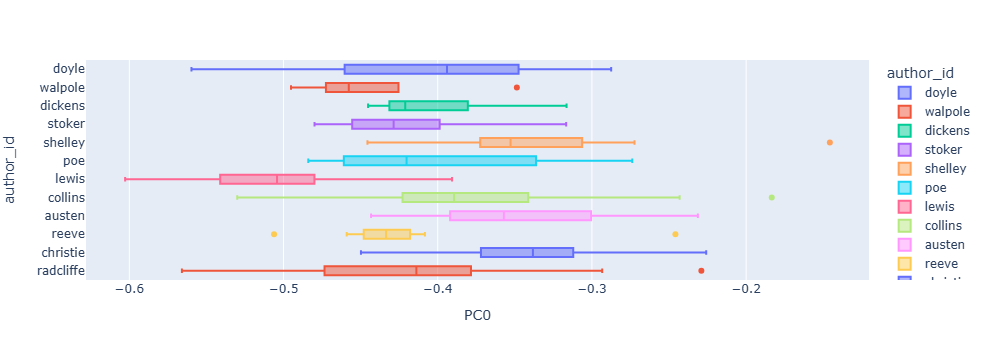

In [14]:
px.box(DCM, 'PC0', 'author_id', color = 'author_id', hover_name = 'doc')

This is an interesting visualization, but it lacks a specific mean value and the exact range isn't easily visible. For the mean, we'll do a quick groupby. But **Collins** appears to have the widest range at approximately 0.35.

In [15]:
DCM.groupby('author_id').agg({'PC0':'mean'})

,PC0
author_id,
austen,-0.347714
christie,-0.344842
collins,-0.378141
dickens,-0.402251
doyle,-0.404029
lewis,-0.509006
poe,-0.397641
radcliffe,-0.417207
reeve,-0.422601


Looking at absolute value, we see here that **Lewis** is the most extreme, with a mean PC0 value of -0.5.

### Question 3: The third PC

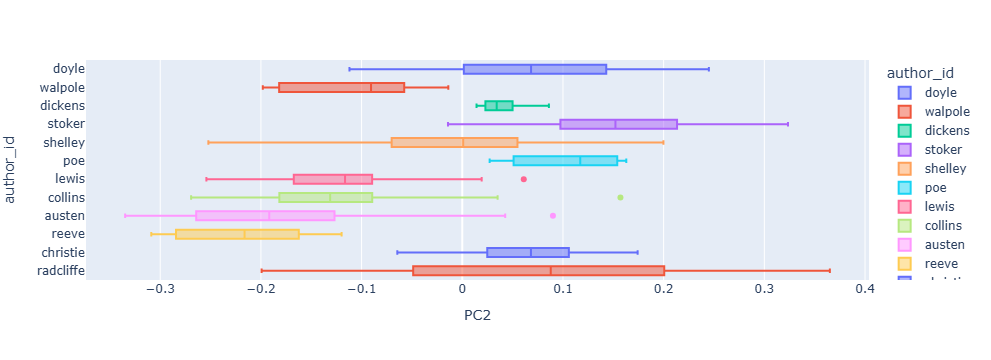

In [16]:
px.box(DCM, 'PC2', 'author_id', color = 'author_id', hover_name = 'doc')

**Radcliffe** has quite easily the maximum range of the third PC.

### Question 4: The second PC

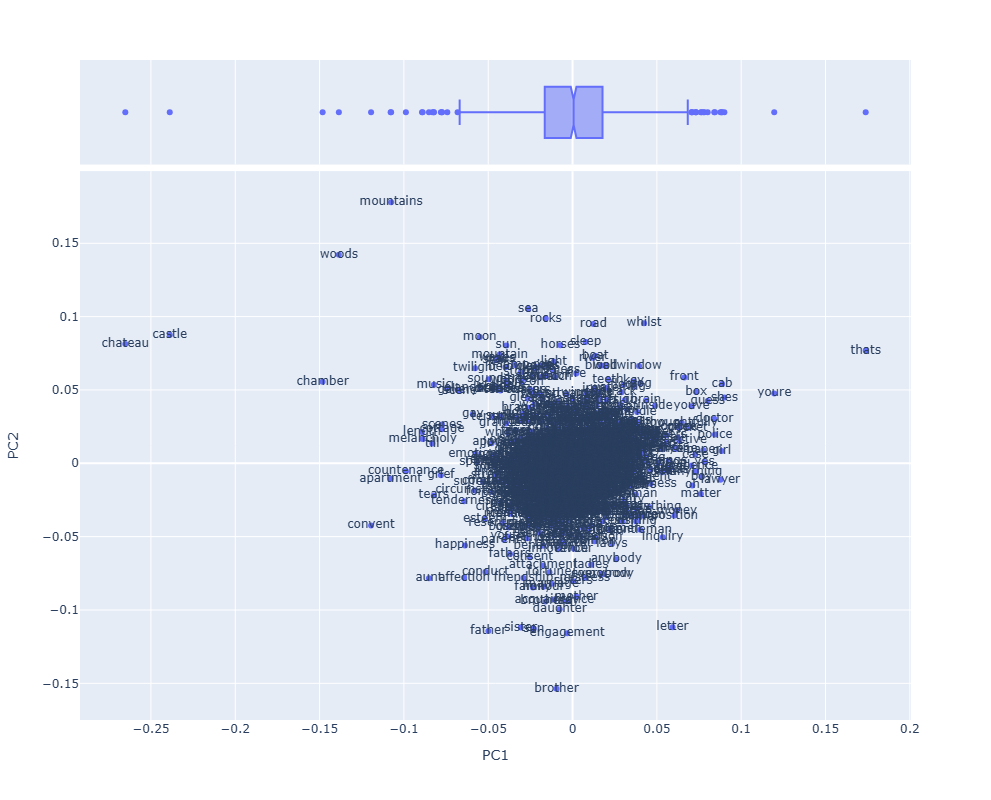

In [24]:
Q4_X = LOADINGS.join(VOCAB_reduced)
px.scatter(Q4_X.reset_index(), 'PC1', 'PC2',
           text='term_str', marginal_x='box', height=800)

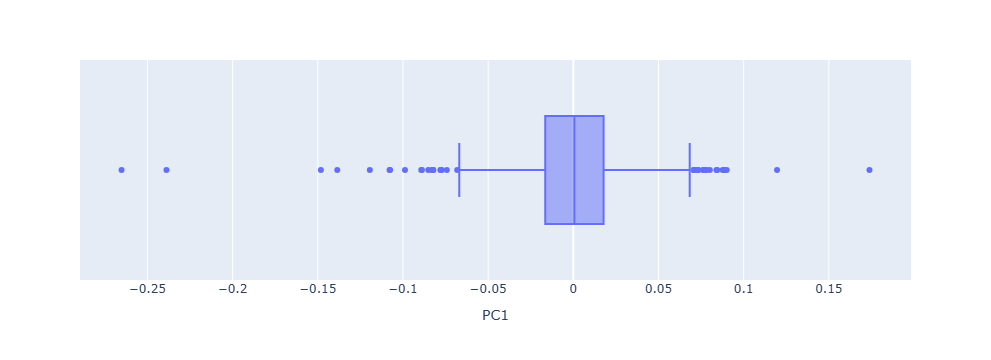

In [26]:
px.box(Q4_X.reset_index(), 'PC1', hover_name = 'term_str')

In [44]:
# not entirely sure that this is the type of visualization desired so here it is in another form
print(list(Q4_X.sort_values(by='PC1').head(3).index))

print(list(Q4_X.sort_values(by='PC1').tail(3).index))

['chateau', 'castle', 'chamber']
['shes', 'youre', 'thats']


This boxplot is a bit of a better visualization for it, though I know that the hover won't show up correctly in my submission. I would characterize it according to the three most extreme values as being "people vs. places", specifically people in the possessive sense (though it is important to note that "thats", "youre", and "shes" probably don't really belong with the other nouns). More than that, though (and this is well reflected in the scatterplot of the DCM above that highlights genre), the positive values of PC1 are more "detective" and the negatives are more "gothic" in my opinion. 

### Question 5: PCA centered by variance

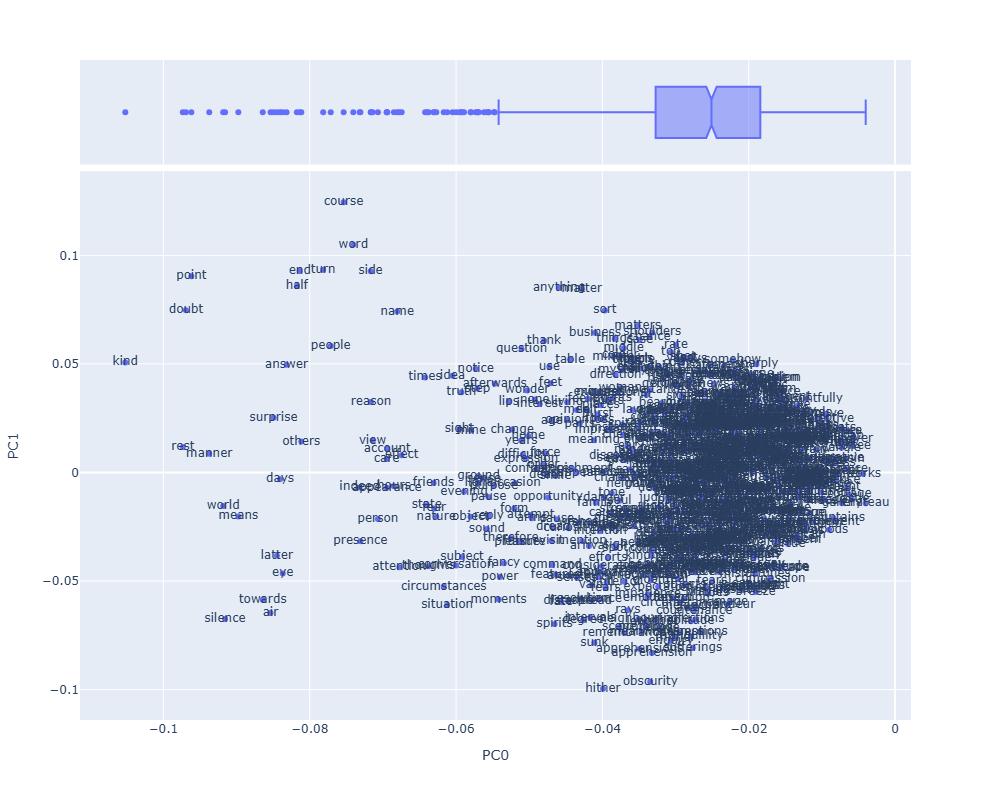

In [28]:
LOADINGS_5, DCM_5, COMPINF_5 = PCA_info(TFIDF_1000, k=10, norm_docs = True, center_by_variance = True)

Q5_X = LOADINGS_5.join(VOCAB_reduced)
px.scatter(Q5_X.reset_index(), 'PC0', 'PC1',
           text='term_str', marginal_x='box', height=800)

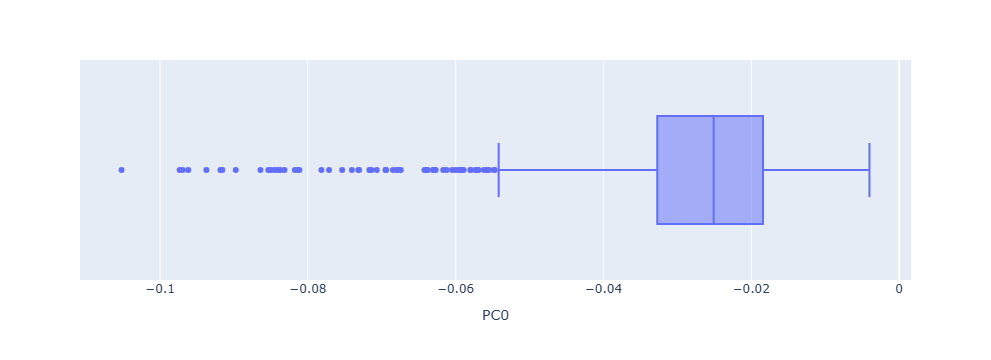

In [30]:
px.box(Q5_X.reset_index(), 'PC0', hover_name = 'term_str')

In [45]:
print(list(Q5_X.sort_values(by='PC0').head(3).index))

print(list(Q5_X.sort_values(by='PC0').tail(3).index))

['kind', 'rest', 'doubt']
['lawyer', 'works', 'chateau']


In [46]:
print(list(Q5_X.sort_values(by='PC1').head(3).index))

print(list(Q5_X.sort_values(by='PC1').tail(3).index))

['hither', 'obscurity', 'apprehension']
['turn', 'word', 'course']


This question was challenging to interpret. I see almost no way to characterize these results if I just look at the first three words. However, this may make sense, because the lecture explained that centering by variance is a bad idea because it puts too much weight on rare words. So, my theory here (though I have to look at more than three words to extrapolate this) is that words that are at opposite poles in the original PCA are now grouped together because of this (like "chateau" and "police") and that this is rather a demonstration of why this is a bad idea. I have also provided extra information because I was looking at the second PC in the question before, and this suggests that I now look at the first PC instead - which is just a touch confusing. I hope I have provided enough explanation here as to my thought process.